In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Enable interactive plot
%matplotlib notebook

## Add Path

In [3]:
import os
import sys

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
del module_path

## Organize imports

In [6]:
from typing import Dict, List, Optional, Tuple, Union

In [7]:
from collections import OrderedDict

In [10]:
from pathlib import Path

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [12]:
import random

In [13]:
import numpy as np

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet18, resnet34, resnet50
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, STL10
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [16]:
import kornia.augmentation as K

In [17]:
from kornia.augmentation.utils import _shape_validation
from kornia.geometry.bbox import bbox_to_mask, infer_bbox_shape
from kornia.constants import BorderType, Resample
from kornia.augmentation import random_generator as rg

In [18]:
import pytorch_lightning as pl

In [19]:
torch.manual_seed(1)

## Universal Approximation

In [20]:
def _init_plt(X, y):
    plt.figure(figsize=(10,4))
    plt.scatter(X, y, color = "orange")
    plt.title('Regression Analysis')
    plt.xlabel('Independent varible')
    plt.ylabel('Dependent varible')
    plt.show()
    fig, ax = plt.subplots(figsize=(12,7))

    return fig, ax

def plot_progress(ax, fig, x_t, y_t, y_hat, loss, t):
    # plot and show learning process
    x_v = x_t.to('cpu').data.numpy()
    y_v = y_t.to('cpu').data.numpy()
    y_hat_v = y_hat.to('cpu').data.numpy()
    ls_v = loss.to('cpu').data.numpy()
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
    ax.scatter(x_v, y_v, color = "orange")
    #         ax.plot(x_v, y_hat_v, 'g-', lw=3)
    ax.scatter(x_v, y_hat_v, color = "blue")
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % ls_v,
            fontdict={'size': 24, 'color':  'red'})

    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer

    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

## Define funcrtions

Define functions for model approximation

#### Function space

In [22]:
def funct_space(xs: np.ndarray, func: callable) -> np.ndarray:
    return func(xs)
    

# Sample X space

Generate random sample from $X$ spaces

$$ 
f(x) = sin(x) + 2x^2 - 3x
$$

In [23]:
def func_mod(x): 
    return np.sin(x) + 2 * x**2 - 3 * x

In [24]:
X_train = np.random.uniform(low=-1, high=1, size=(2 * 4 * 4 * 200,))
X_test = np.random.uniform(low=-1, high=1, size=(1000,))
X_train.shape, X_test.shape

((6400,), (1000,))

In [25]:
y_train = funct_space(X_train, func_mod)
y_test = funct_space(X_test, func_mod)
y_train.shape, y_test.shape

((6400,), (1000,))

<IPython.core.display.Javascript object>


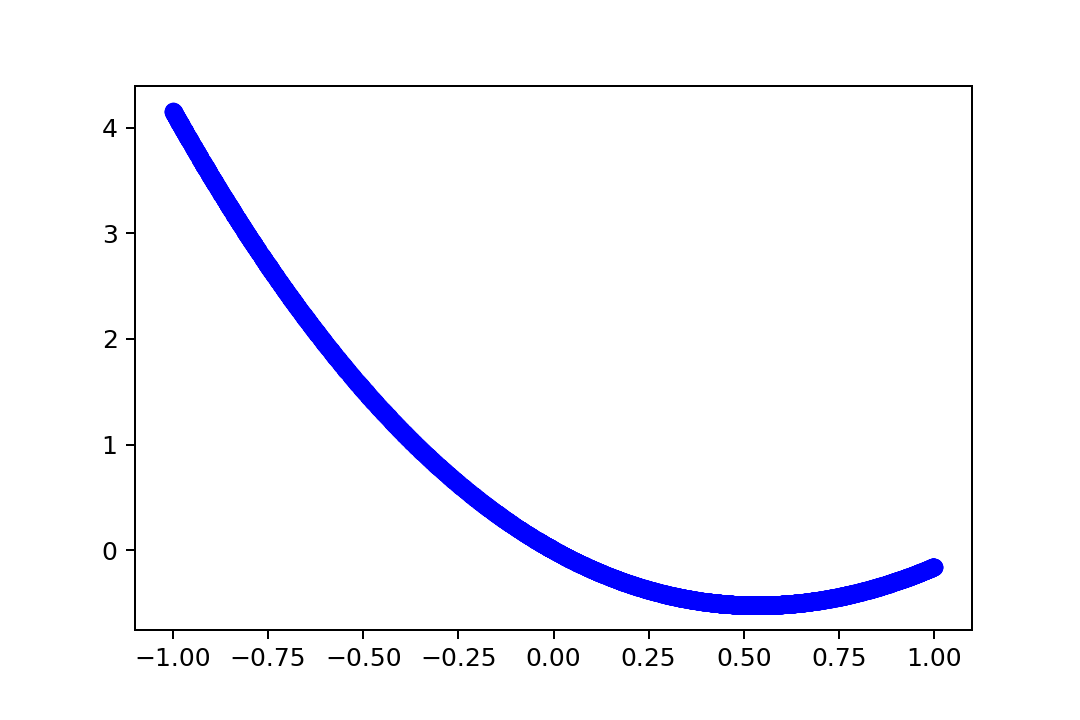

In [26]:
plt.plot(X_train, y_train, 'bo')
plt.show()
# plt.close()

## Define model

In [27]:
def init_net(
    in_features = 1, out_features = 1, hidden_features = 10, h_mul = 1):
    return nn.Sequential(OrderedDict([
            ('fn1', nn.Linear(in_features, hidden_features, bias=True)),
            ('a1', nn.ReLU()),
        ]))

In [28]:
def init_net_1(
    in_features = 1, out_features = 1, hidden_features = 10, h_mul = 1):
    return nn.Sequential(OrderedDict([
            ('fn1', nn.Linear(in_features, hidden_features, bias=True)),
            ('a1', nn.ReLU()),
            ('fn2', nn.Linear(hidden_features, out_features, bias=True)),
        ]))

In [29]:
def init_net_2(
    in_features = 1, out_features = 1, hidden_features = 8, h_mul = 1):
    return nn.Sequential(OrderedDict([
            ('fn1', nn.Linear(in_features, hidden_features, bias=True)),
            ('a1', nn.ReLU()),
            ('d1', nn.Dropout(p = 0.25)),
            ('fn2', nn.Linear(hidden_features, h_mul * hidden_features, bias=True)),
            ('a2', nn.ReLU()),
            ('d2', nn.Dropout(p = 0.5)),
            ('fn3', nn.Linear(h_mul * hidden_features, out_features, bias=True)),
        ]))

In [30]:
def init_net_3(
    in_features = 1, out_features = 1, hidden_features = 8, h_mul = 1):
    return nn.Sequential(OrderedDict([
            ('fn1', nn.Linear(in_features, hidden_features, bias=True)),
            ('a1', nn.ReLU()),
            ('fn2', nn.Linear(hidden_features, h_mul * hidden_features, bias=True)),
            ('a2', nn.ReLU()),
            ('fn3', nn.Linear(h_mul * hidden_features, h_mul * hidden_features, bias=True)),
            ('a3', nn.ReLU()),
            ('fn4', nn.Linear(h_mul * hidden_features, out_features, bias=True)),
        ]))

In [31]:
def init_net_4(
    in_features = 1, out_features = 1, hidden_features = 8, h_mul = 1):
    return nn.Sequential(OrderedDict([
            ('fn1', nn.Linear(in_features, hidden_features, bias=True)),
            ('a1', nn.ReLU()),
            ('fn2', nn.Linear(hidden_features, h_mul * hidden_features, bias=True)),
            ('a2', nn.ReLU()),
            ('fn3', nn.Linear(h_mul * hidden_features, hidden_features, bias=True)),
            ('a3', nn.ReLU()),
            ('fn4', nn.Linear(h_mul * hidden_features, hidden_features, bias=True)),
            ('a4', nn.ReLU()),
            ('fn5', nn.Linear(hidden_features, out_features, bias=True)),
        ]))

## Train model

In [32]:
def to_tensors(X, y):
    X_t = torch.unsqueeze(torch.Tensor(X), dim=1)
    y_t = torch.unsqueeze(torch.Tensor(y), dim=1)
    
    return X_t, y_t

In [33]:
def train(
    net: nn.Module, optimizer, loss, X, y, epochs: int = 1000):
    fig, ax = _init_plt(X, y)
    net.train()
    X_t, y_t = to_tensors(X, y)
    for ep in tqdm(range(epochs), desc='Training the model'):
        y_hat = net(X_t)
        ls = loss(y_hat, y_t)
        optimizer.zero_grad()
        ls.backward()
        optimizer.step()
        img = plot_progress(ax, fig, X_t, y_t, y_hat, ls, ep + 1)
    

In [34]:
net = init_net_3(hidden_features=8, h_mul=2)
net

Sequential(
  (fn1): Linear(in_features=1, out_features=8, bias=True)
  (a1): ReLU()
  (fn2): Linear(in_features=8, out_features=16, bias=True)
  (a2): ReLU()
  (fn3): Linear(in_features=16, out_features=16, bias=True)
  (a3): ReLU()
  (fn4): Linear(in_features=16, out_features=1, bias=True)
)

<IPython.core.display.Javascript object>


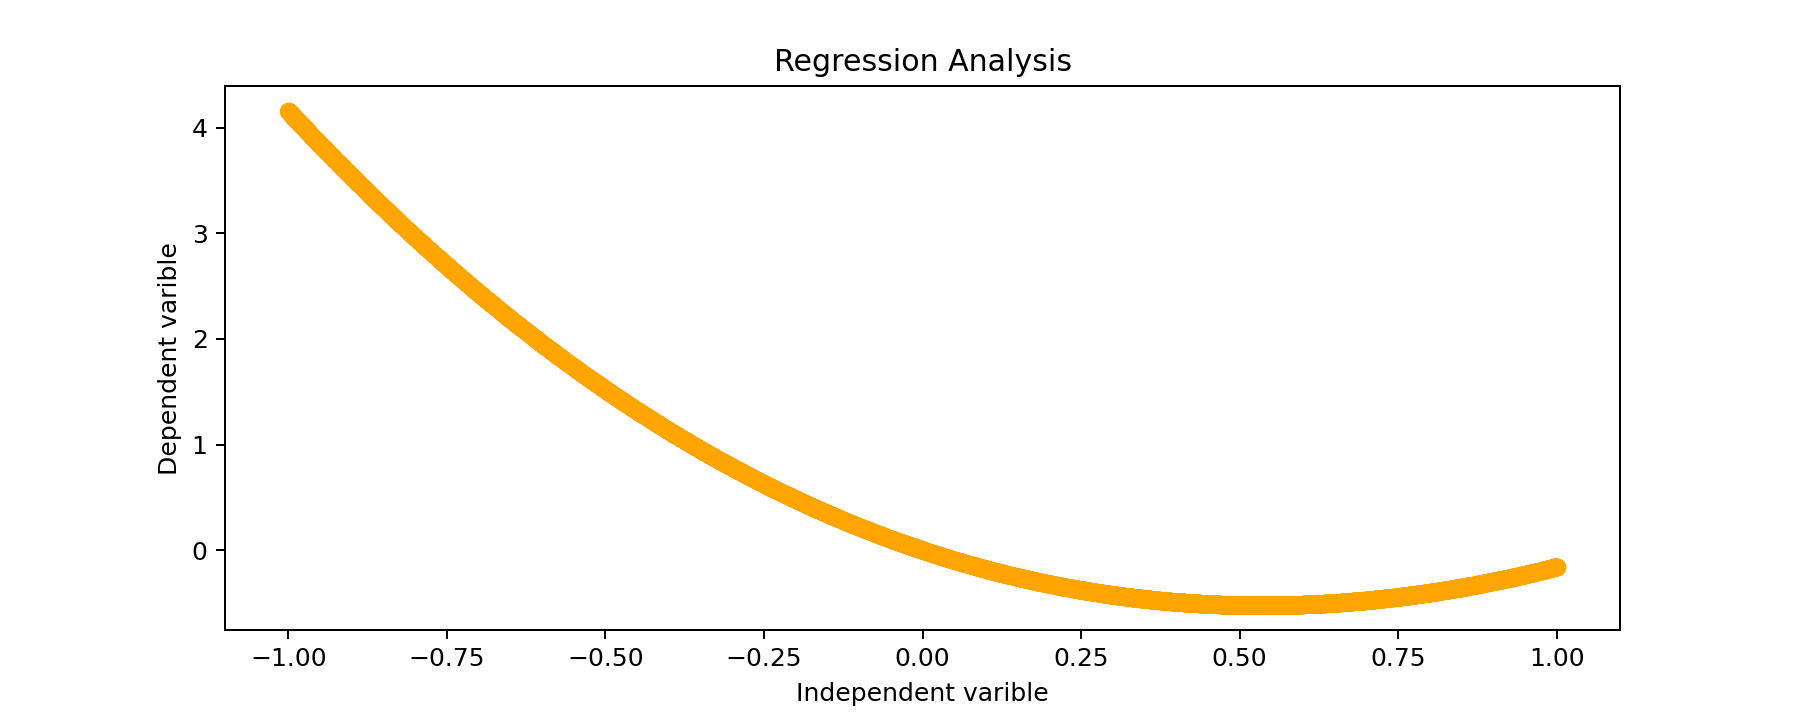

<IPython.core.display.Javascript object>


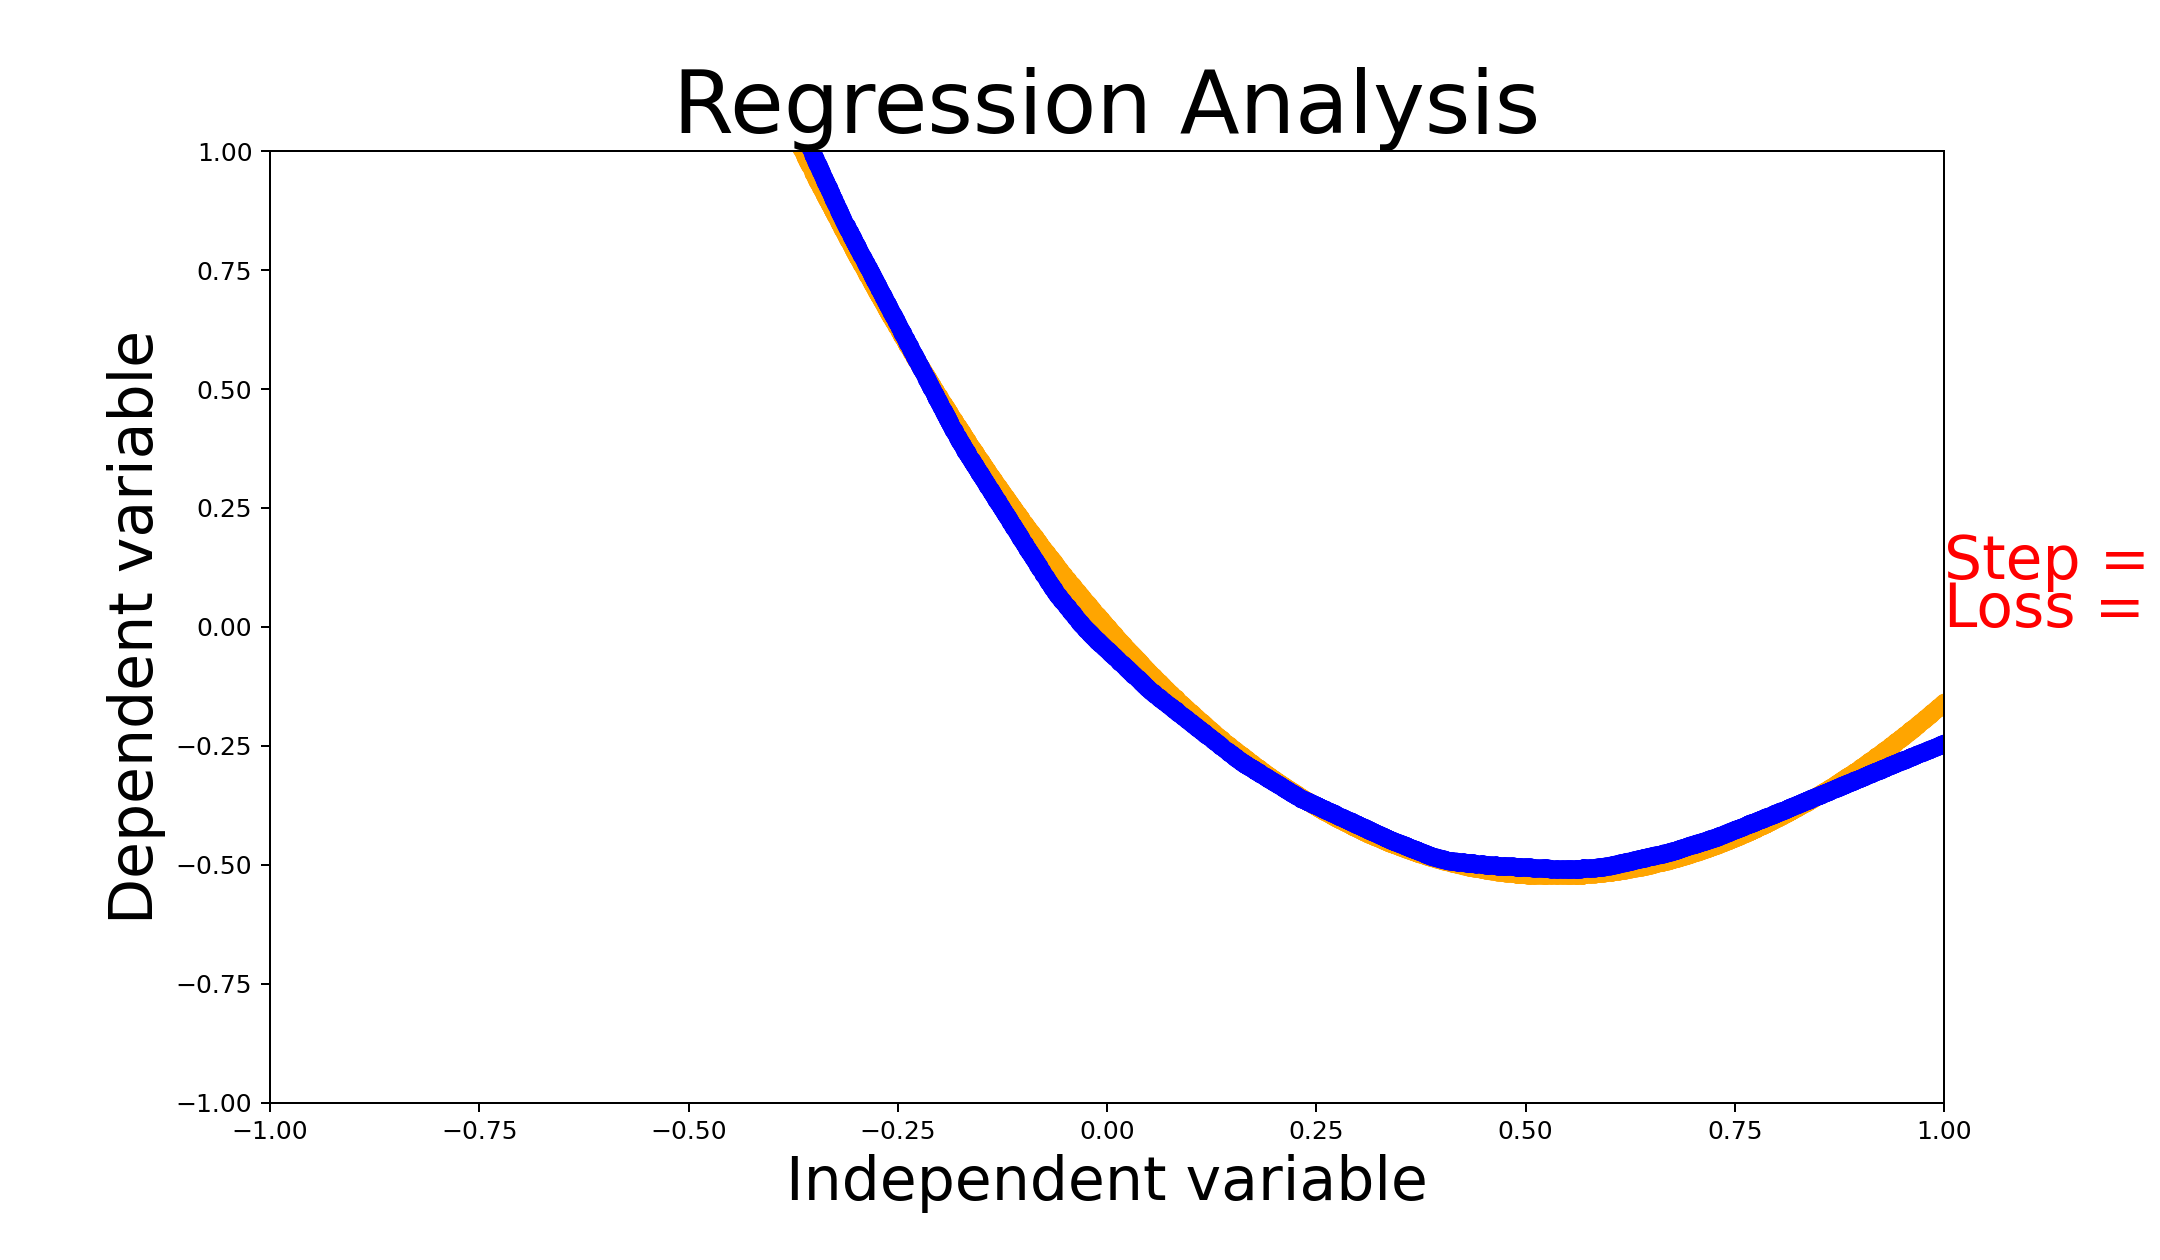

Training the model:   0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
net = init_net_1(hidden_features=32 * 2, h_mul=4)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss = torch.nn.MSELoss()
epochs  = 2 * 500
train(
    net, optimizer, loss, X_train, y_train, epochs=epochs)

In [36]:
net

Sequential(
  (fn1): Linear(in_features=1, out_features=64, bias=True)
  (a1): ReLU()
  (fn2): Linear(in_features=64, out_features=1, bias=True)
)

In [37]:
X_test = np.random.uniform(low=-1, high=1, size=(10000,))
y_test = funct_space(X_test, lambda x: x**2)

In [38]:
def test(net: nn.Module, X, y):
    net.eval()
    X_t = torch.unsqueeze(torch.Tensor(X), dim=1)
    y_hat_t = net(X_t)
    y_hat = y_hat_t.to('cpu').data.numpy()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(X, y, s=10, c='b', marker="s", label='ground true')
    ax1.scatter(X, y_hat, s=10, c='r', marker="o", label='predicted')
    plt.legend(loc='upper left');
    plt.show()

<IPython.core.display.Javascript object>


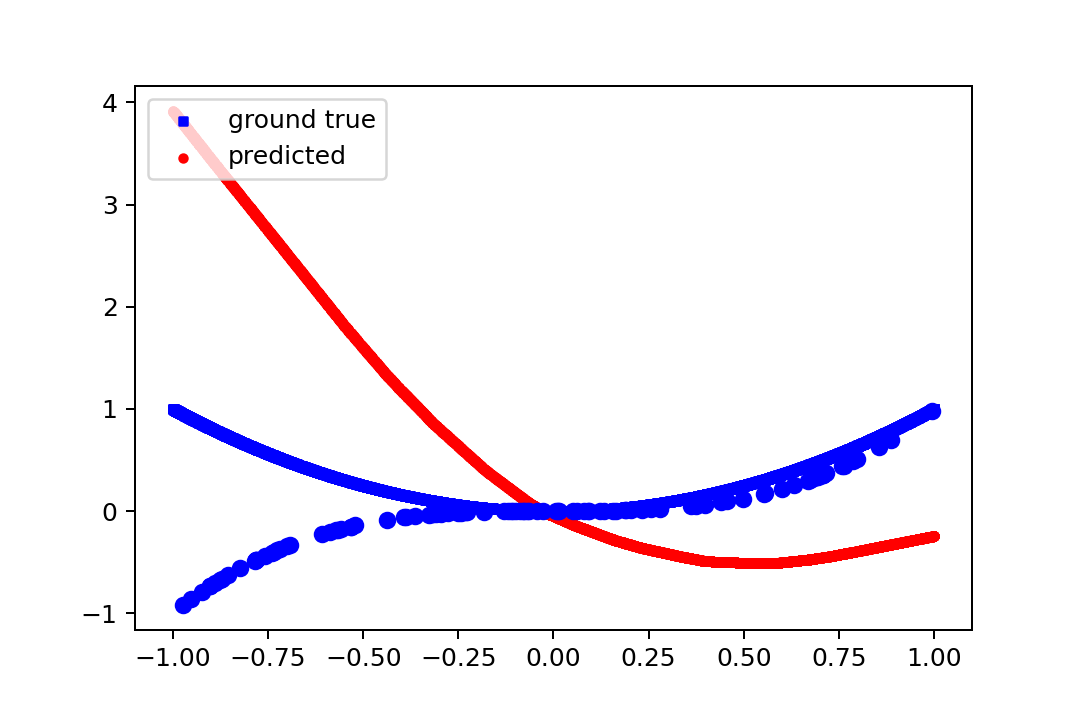

In [39]:
test(net, X_test, y_test)

In [40]:
X_test.shape, y_test.shape

((10000,), (10000,))

## Transfer learning

In [46]:
X_d = np.random.uniform(low=-1, high=1, size=(50,))
y_d = funct_space(X_d, lambda x: x**3)

In [47]:
X_d.shape, y_d.shape

((50,), (50,))

In [48]:
plt.plot(X_d, y_d, 'bo')
plt.show()

In [49]:
net[:-1]

Sequential(
  (fn1): Linear(in_features=1, out_features=64, bias=True)
  (a1): ReLU()
)

In [50]:
fc_d = nn.Linear(
    net[-1].in_features, net[-1].out_features, bias=True)
net_d = nn.Sequential(net[:-1], fc_d)
net_d, net_d[-1]

(Sequential(
   (0): Sequential(
     (fn1): Linear(in_features=1, out_features=64, bias=True)
     (a1): ReLU()
   )
   (1): Linear(in_features=64, out_features=1, bias=True)
 ),
 Linear(in_features=64, out_features=1, bias=True))

<IPython.core.display.Javascript object>


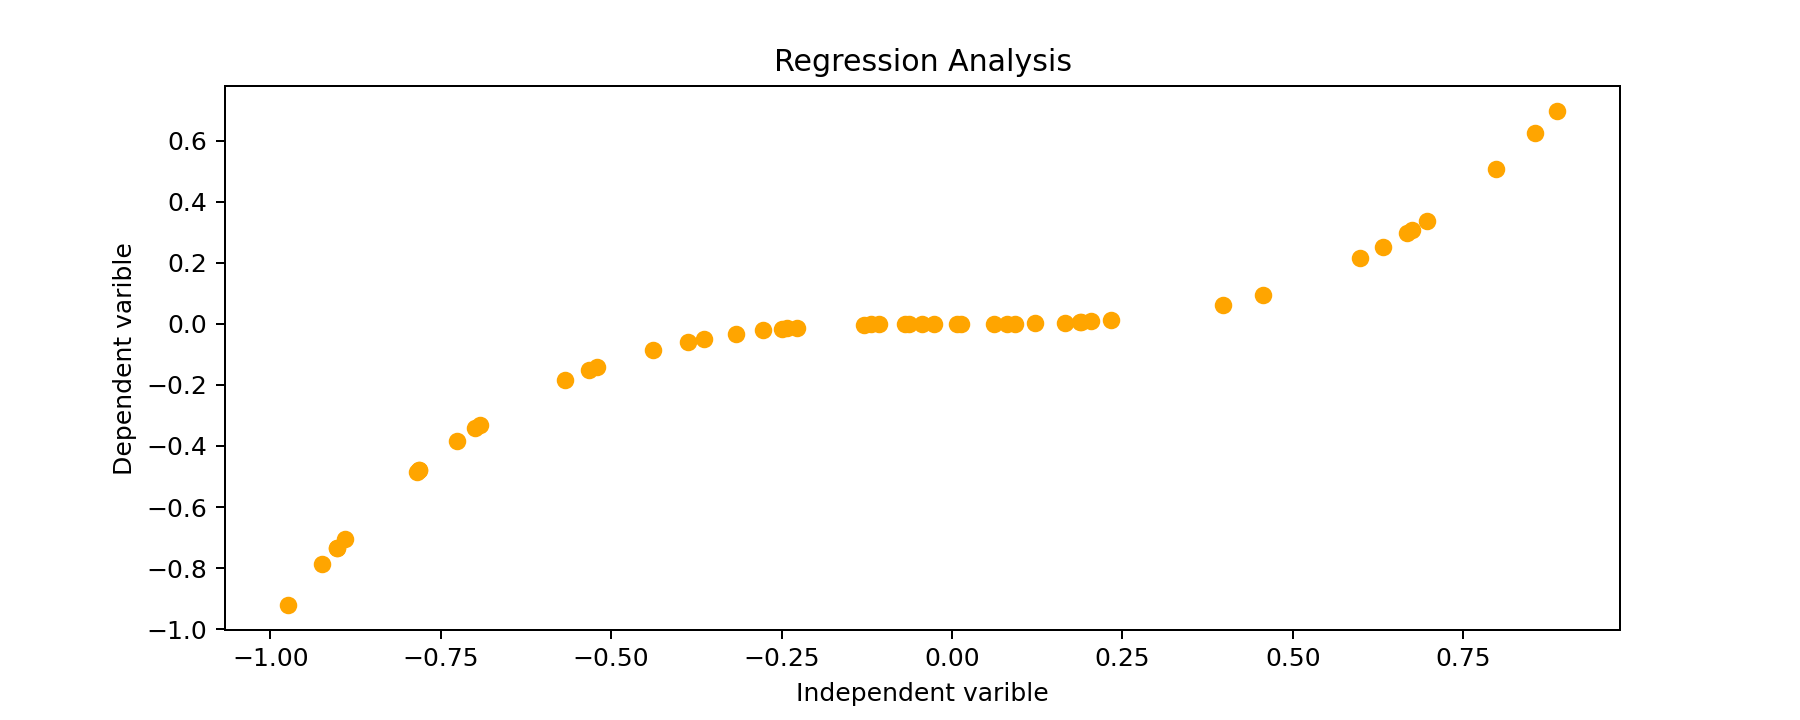

<IPython.core.display.Javascript object>


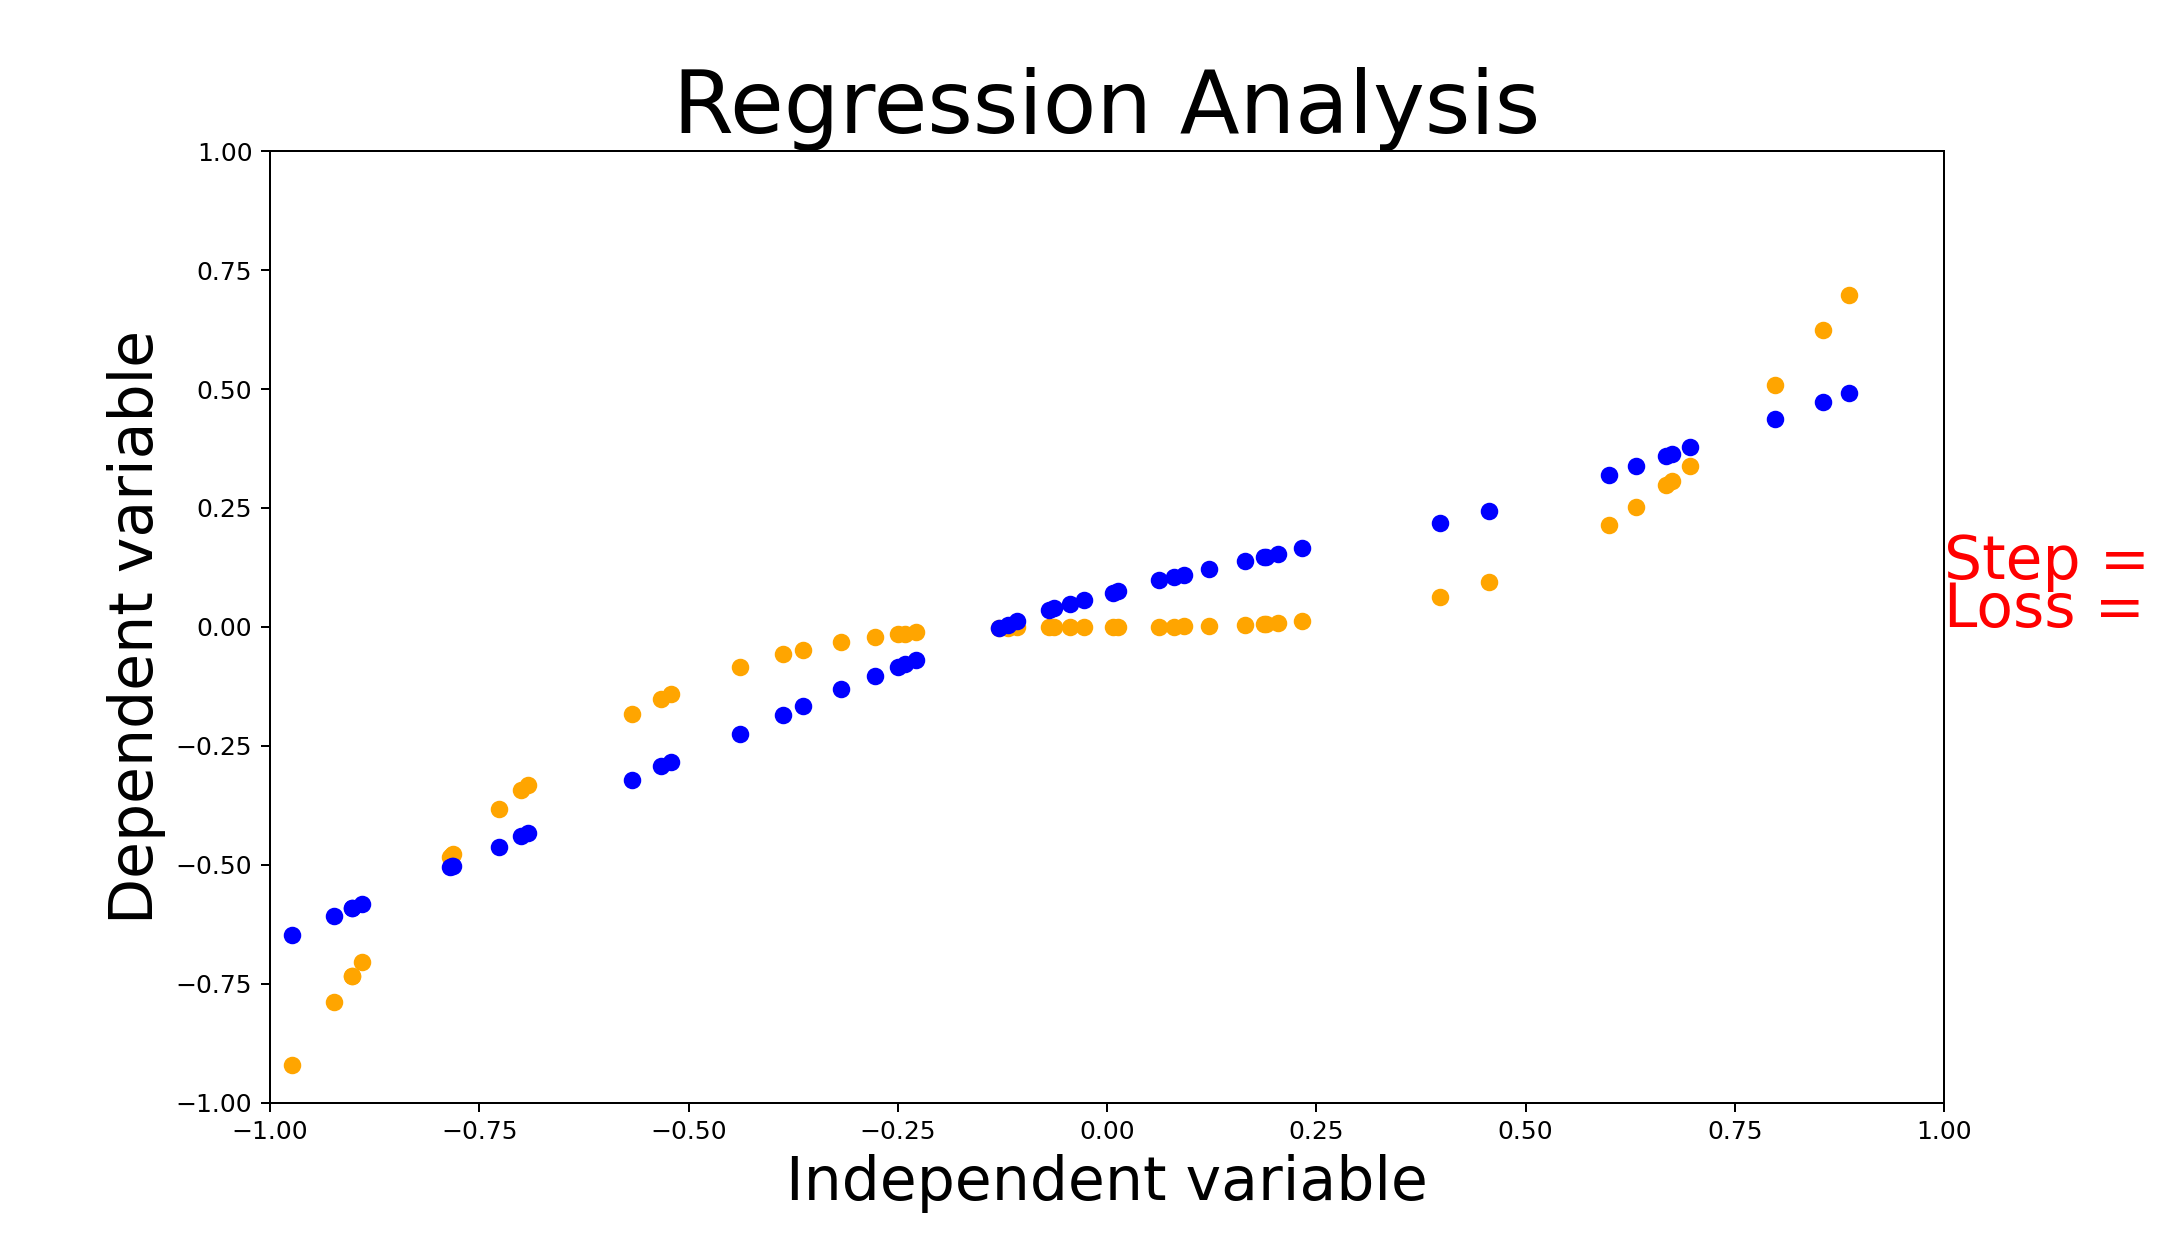

Training the model:   0%|          | 0/50 [00:00<?, ?it/s]

In [51]:
optimizer_d = torch.optim.SGD(net_d[-1].parameters(), lr=0.01, momentum=0.9)
loss_d = torch.nn.MSELoss()
epochs_d  = 50
train(
    net_d, optimizer_d, loss_d, X_d, y_d, epochs=epochs_d)

In [52]:
X_d_test = np.random.uniform(low=-1, high=1, size=(10000,))
y_d_test = funct_space(X_d_test, lambda x: x**3)
X_d_test.shape, y_d_test.shape

((10000,), (10000,))

<IPython.core.display.Javascript object>


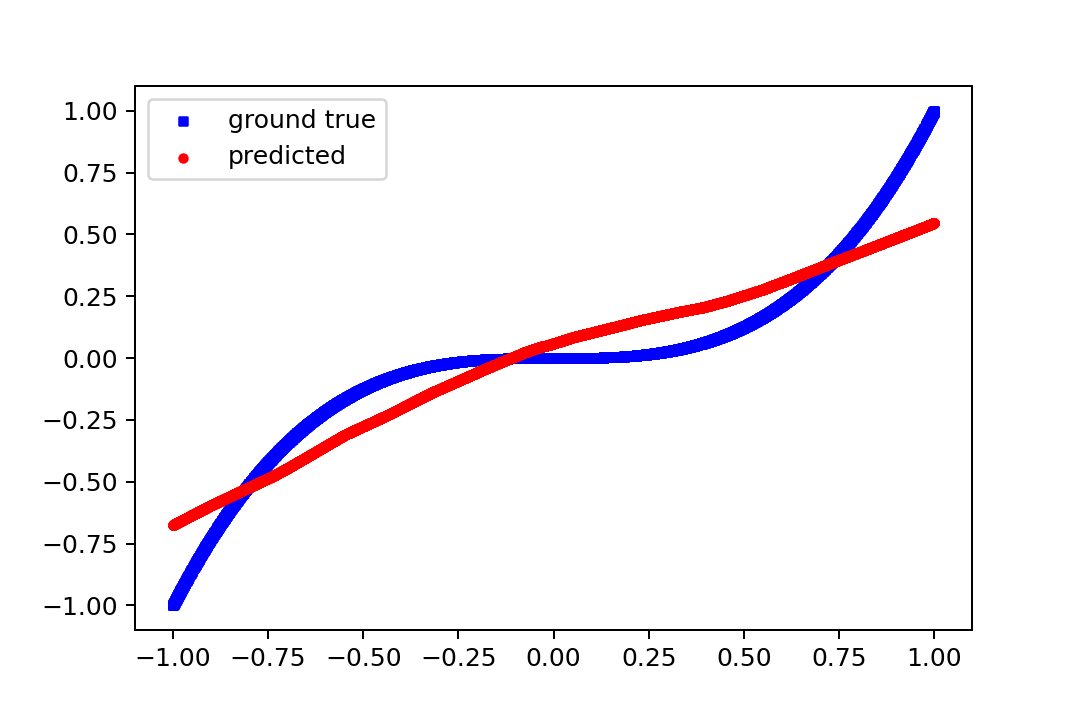

In [53]:
test(net_d, X_d_test, y_d_test)

In [54]:
?? init_net_1

## Compare with method from scratch

<IPython.core.display.Javascript object>


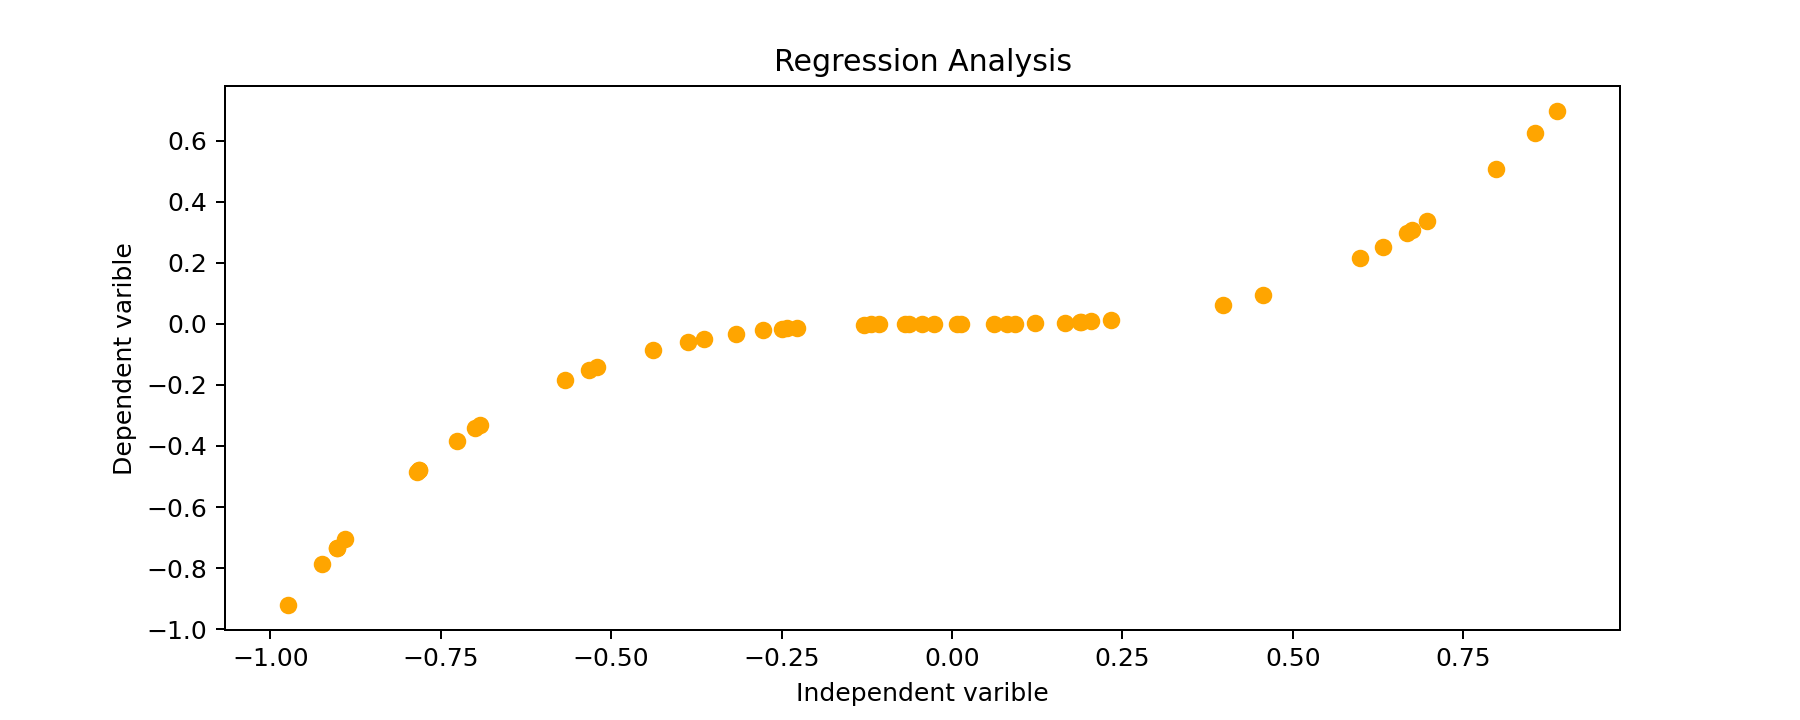

<IPython.core.display.Javascript object>


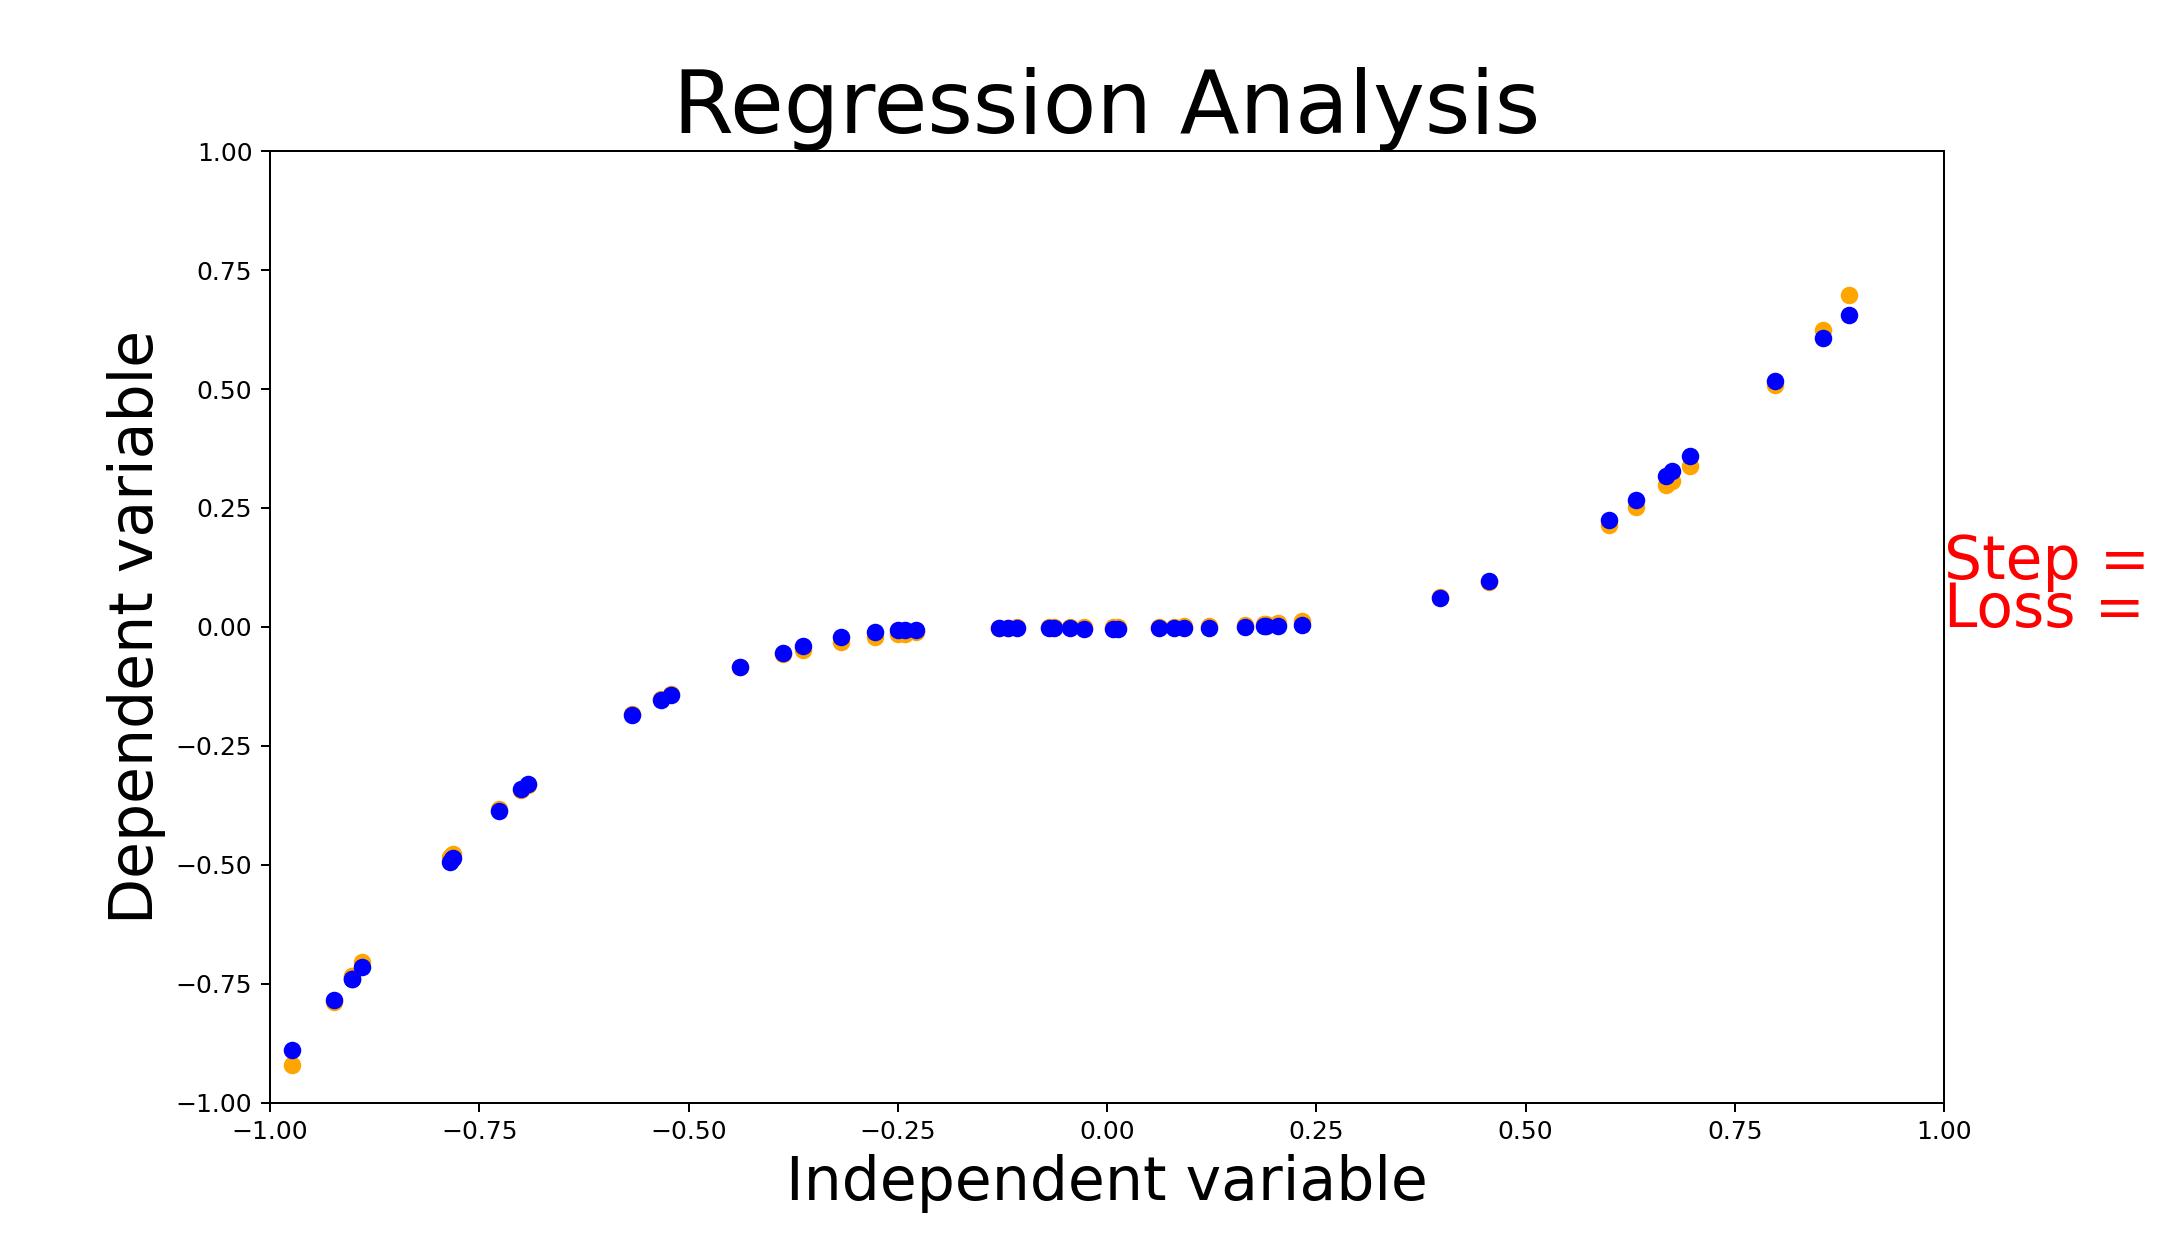

Training the model:   0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
net_sc = init_net_1(hidden_features=32 * 4 * 2, h_mul=4)
optimizer_sc = torch.optim.SGD(net_sc.parameters(), lr=0.01, momentum=0.9)
loss_sc = torch.nn.MSELoss()
epochs_sc  = 50
train(
    net_sc, optimizer_sc, loss_sc, X_d, y_d, epochs=epochs_sc * 20)

<IPython.core.display.Javascript object>


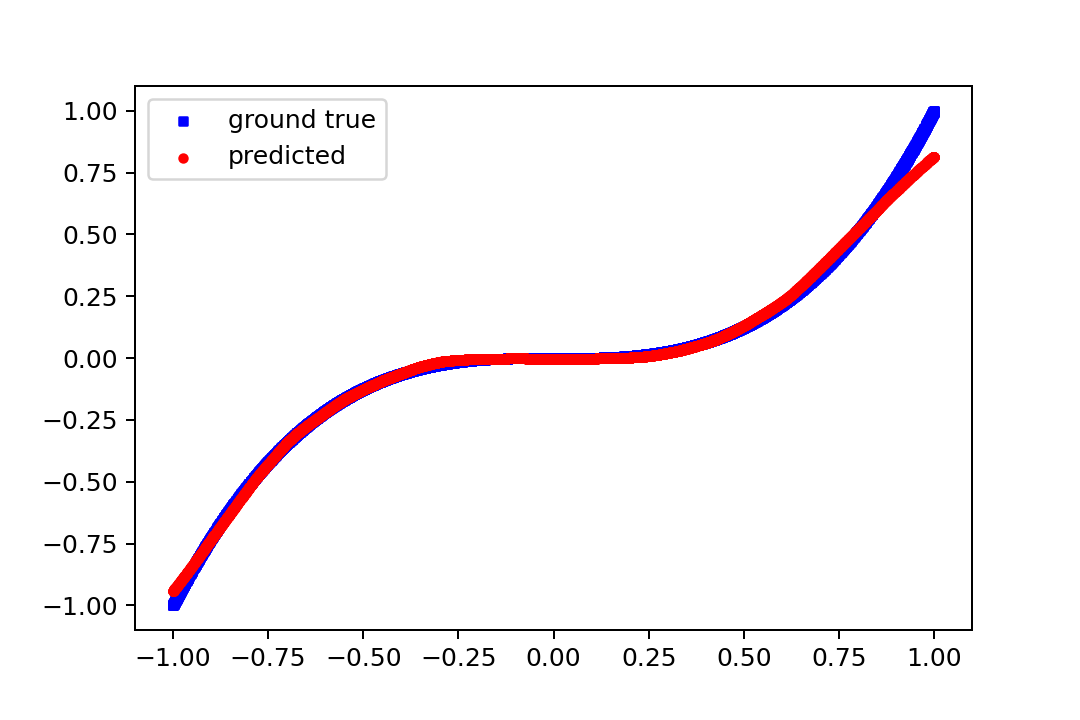

In [60]:
test(net_sc, X_d_test, y_d_test)